# Current Models

---

Aditya Marathe

**Aims**:
- Compare the two models which were/are used in the analysis of the NOvA results.
    - Calculate and compare their energy resolutions.
- Compare the current models with my latest model.

## Imports

In [43]:
import os
import sys

import pathlib

In [44]:
%matplotlib inline

import dotenv

import h5py
import pandas as pd

import numpy as np
import numpy.typing as npt
import scipy as sp

import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing

import matplotlib as mpl
import matplotlib.pyplot as plt

**Version and hardware**:

In [45]:
print(f'Python {sys.version}\n')
print(f'H5Py {h5py.__version__}')
print(f'Pandas {pd.__version__}')
print(f'NumPy {np.__version__}')
print(f'SciPy {sp.__version__}')
print(f'TensorFlow {tf.__version__}')
print(f'Keras {keras.__version__}')
print(f'Matplotlib {mpl.__version__}')

Python 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]

H5Py 3.10.0
Pandas 2.1.2
NumPy 1.26.1
SciPy 1.11.3
TensorFlow 2.10.1
Keras 2.10.0
Matplotlib 3.8.1


**Local modules**:

In [46]:
sys.path.insert(1, './../')

from cuts import Cuts
from utils import * 

**Load the enviornment variables**:

In [47]:
dotenv.load_dotenv();

## Loading the data

In [48]:
file_dir = pathlib.Path(os.environ['MINI_DATA_DIR'])
n_events = 5_000_000

with h5py.File(file_dir, 'r') as file:
    df = pd.DataFrame(data={key:file[key][:n_events] for key in file.keys()})

In [49]:
# We want data for energy which makes sense
df = df[df['rec.energy.numu.lstmnu'] > 0]
df = df[df['rec.energy.numu.E'] > 0]

In [50]:
nova_cuts = Cuts.init_nova_cuts()

In [51]:
df_full_cuts = nova_cuts.apply_all_cuts(df)

## Plot of the recent models

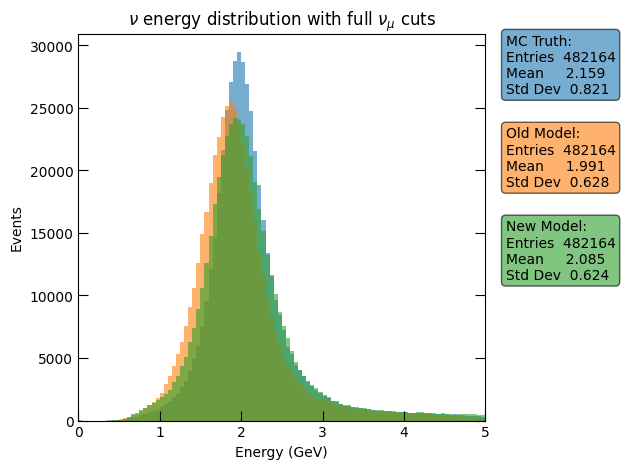

In [52]:
fig, ax = custom_subplots()

alpha_conf = 0.6
bins_conf = np.linspace(0, 5, 100 + 1)

labelled_hist(
    ax, 
    df_full_cuts['trueEnu'], 
    bins=bins_conf, 
    alpha=alpha_conf, 
    label='MC Truth'
)

labelled_hist(
    ax, 
    df_full_cuts['rec.energy.numu.E'], 
    bins=bins_conf, 
    alpha=alpha_conf, 
    label='Old Model'
)

labelled_hist(
    ax, 
    df_full_cuts['rec.energy.numu.lstmnu'], 
    bins=bins_conf, 
    alpha=alpha_conf, 
    label='New Model'
)

ax.set_xlim(0, 5)

ax.set_title(r'$\nu$ energy distribution with full $\nu_\mu$ cuts')

ax.set_xlabel(r'Energy (GeV)')
ax.set_ylabel(r'Events')

plt.tight_layout();


## Combined energy resolution

The energy resolution of the model is equal to the root-mean-square (RMS) of the following distribution which is, in essence, the residual distribution:

$$
    \frac{E_\text{truth} - E_\text{model}}{E_\text{truth}} = 1 - \frac{E_\text{model}}{E_\text{truth}}
$$

In [53]:
def calculate_residuals(
        observed_data: pd.Series | npt.NDArray,
        expected_data: pd.Series | npt.NDArray
    ) -> pd.Series | npt.NDArray:
    """
    Calculates the normalised residual using the following formula:
        residuals (%) = 1 - (observed data / expected data)
    """
    return 1 - (observed_data / expected_data)

In [54]:
eres_old_model = calculate_residuals(
    observed_data=df_full_cuts[df_full_cuts['trueEnu'] > 0]['rec.energy.numu.E'],
    expected_data=df_full_cuts[df_full_cuts['trueEnu'] > 0]['trueEnu']
)

In [55]:
eres_new_model = calculate_residuals(
    observed_data=df_full_cuts[df_full_cuts['trueEnu'] > 0]['rec.energy.numu.lstmnu'],
    expected_data=df_full_cuts[df_full_cuts['trueEnu'] > 0]['trueEnu']
)

In [56]:
bins_conf = np.linspace(-1, 1, 50)

In [57]:
# Fitting a Gaussian

def gaussian(x: float, a: float, b: float, c: float) -> float:
    """\
    General form of a Gaussian function.

    a = amplitude
    b = mean
    c = standard deviation
    """
    return a * np.exp(-(x - b)**2 / (2 * c**2))


values_new, bin_edges_new = np.histogram(
    eres_new_model, 
    bins=bins_conf
)
bin_centers_new = (bin_edges_new[:-1] + bin_edges_new[1:]) / 2

p_guess = [
    80_000,
    np.mean(eres_new_model),
    np.std(eres_new_model)
]
p_new, cov_new = sp.optimize.curve_fit(
    # Fit function
    gaussian, 
    # X, Y values
    bin_centers_new, 
    values_new, 
    # Initial guess
    p0=p_guess
)

err_new = np.sqrt(np.diag(cov_new))

# ==============================================================================

values_old, bin_edges_old = np.histogram(
    eres_old_model, 
    bins=bins_conf
)
bin_centers_old = (bin_edges_old[:-1] + bin_edges_old[1:]) / 2

p_guess = [
    60_000,
    np.mean(eres_old_model),
    np.std(eres_old_model)
]
p_old, cov_old = sp.optimize.curve_fit(
    # Fit function
    gaussian, 
    # X, Y values
    bin_centers_old, 
    values_old, 
    # Initial guess
    p0=p_guess
)

err_old = np.sqrt(np.diag(cov_old))


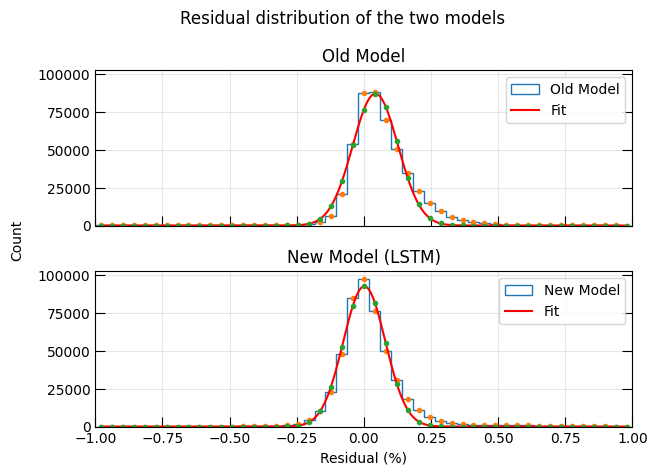

In [58]:
fig, axs = custom_subplots(2, 1, sharex=True, sharey=True)

alpha_conf = 1.
bin_centers_old_2 = np.linspace(
    min(bin_centers_old), 
    max(bin_centers_old), 
    1_000
)
bin_centers_new_2 = np.linspace(
    min(bin_centers_new), 
    max(bin_centers_new), 
    1_000
)

axs[0].hist(
    eres_old_model,
    bins=bins_conf,
    alpha=alpha_conf,
    histtype='step',
    label='Old Model'
)
axs[0].plot(
    bin_centers_old, 
    values_old, 
    '.'
)
axs[0].plot(
    bin_centers_old_2, 
    gaussian(bin_centers_old_2, *p_old),
    'r-',
    label='Fit'
)
axs[0].plot(
    bin_centers_old, 
    gaussian(bin_centers_old, *p_old),
    '.'
)

# ==============================================================================

axs[1].hist(
    eres_new_model,
    bins=bins_conf,
    alpha=alpha_conf,
    histtype='step',
    label='New Model'
)
axs[1].plot(
    bin_centers_new, 
    values_new, 
    '.'
)
axs[1].plot(
    bin_centers_new_2, 
    gaussian(bin_centers_new_2, *p_new),
    'r-',
    label='Fit'
)
axs[1].plot(
    bin_centers_new, 
    gaussian(bin_centers_new, *p_new),
    '.'
)

#
axs[1].set_xlabel('Residual (%)')
fig.text(-0.02, 0.5, 'Count', va='center', rotation='vertical')

axs[0].set_xlim(-1, 1)
axs[0].grid(True, alpha=0.3)
axs[1].grid(True, alpha=0.3)

fig.suptitle('Residual distribution of the two models')
axs[0].set_title('Old Model')
axs[1].set_title('New Model (LSTM)')

axs[0].legend()
axs[1].legend()

plt.tight_layout();

In [59]:
summary = """\
Old Model
---------
Entries  ......  {}
Mean  .........  {:0.5f}
Std Dev  ......  {:0.5f}

New Model
---------
Entries  ......  {}
Mean  .........  {:0.5f}
Std Dev  ......  {:0.5f}
""".format(
    len(eres_old_model),
    np.mean(eres_old_model),
    np.std(eres_old_model),
    len(eres_new_model),
    np.mean(eres_new_model),
    np.std(eres_new_model)
)
print(summary)

Old Model
---------
Entries  ......  482140
Mean  .........  0.06737
Std Dev  ......  0.12518

New Model
---------
Entries  ......  482140
Mean  .........  0.02246
Std Dev  ......  0.12128



## Resolution of energy fractions

### Calculating energy fractions

In [60]:
energy_frac_old = (df_full_cuts['rec.energy.numu.hadclust.calE'] 
                    / df_full_cuts['rec.energy.numu.E'])

q1_old = energy_frac_old.quantile(q=0.25)
q2_old = energy_frac_old.quantile(q=0.50)
q3_old = energy_frac_old.quantile(q=0.75)

energy_frac_cuts_old = [
    (energy_frac_old <= q1_old),
    (energy_frac_old > q1_old) & (energy_frac_old <= q2_old),
    (energy_frac_old > q2_old) & (energy_frac_old <= q3_old),
    (energy_frac_old > q3_old)
]

# ==============================================================================

energy_frac_new = (df_full_cuts['rec.energy.numu.hadclust.calE'] 
                    / df_full_cuts['rec.energy.numu.lstmnu'])

q1_new = energy_frac_new.quantile(q=0.25)
q2_new = energy_frac_new.quantile(q=0.50)
q3_new = energy_frac_new.quantile(q=0.75)

energy_frac_cuts_new = [
    energy_frac_new <= q1_new,
    (energy_frac_new > q1_new) & (energy_frac_new <= q2_new),
    (energy_frac_new > q2_new) & (energy_frac_new <= q3_new),
    (energy_frac_new > q3_new)
]

### Old Model

C:\Users\Shrey\AppData\Local\Temp\ipykernel_12452\3708727919.py:35: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend(


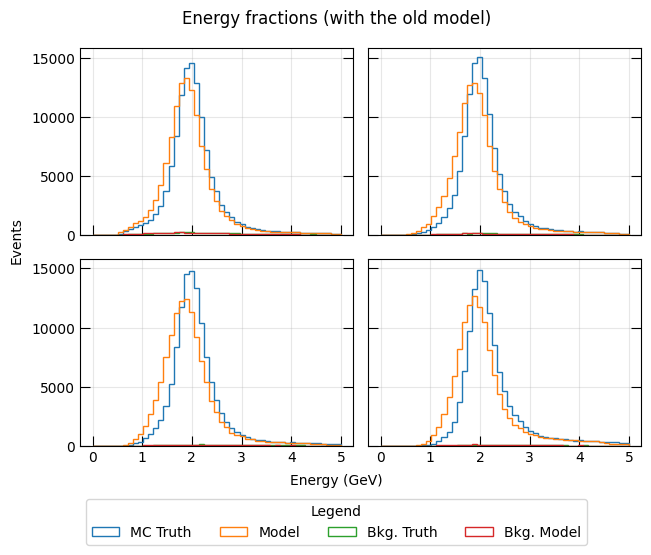

In [61]:
fig, axs = custom_subplots(2, 2, sharex=True, sharey=True)

axs = axs.flatten()

bins_conf = np.linspace(0, 5, 50)
model = 'rec.energy.numu.E'

for i in range(4):
    df_energy_frac = df_full_cuts[energy_frac_cuts_old[i]]
    
    axs[i].hist(
       df_energy_frac['trueEnu'],
        bins=bins_conf,
        histtype='step'
    )
    axs[i].hist(
        df_energy_frac[model],
        bins=bins_conf,
        histtype='step'
    )
    axs[i].hist(
        df_energy_frac[df_energy_frac['isNuMuCC'] == 0]['trueEnu'],
        bins=bins_conf,
        histtype='step'
    )
    axs[i].hist(
        df_energy_frac[df_energy_frac['isNuMuCC'] == 0][model],
        bins=bins_conf,
        histtype='step'
    )

    axs[i].grid(True, alpha=0.3)


fig.legend(
    axs[0].lines, 
    labels=[
        'MC Truth', 
        'Model',
        'Bkg. Truth',
        'Bkg. Model'
    ], 
    loc='lower center',
    ncol=4,
    bbox_to_anchor=(0.5, -0.15), 
    title='Legend'
)

fig.text(-0.01, 0.5, 'Events', va='center', rotation='vertical')
fig.text(0.5, -0.01, 'Energy (GeV)', ha='center', rotation='horizontal')

fig.suptitle('Energy fractions (with the old model)')

plt.tight_layout();

In [62]:
residuals_old = list()
purity_old = list()

for i in range(4):
    df_energy_frac = df_full_cuts[energy_frac_cuts_old[i]]

    residuals_old.append(
        calculate_residuals(
            df_energy_frac[df_energy_frac['trueEnu'] > 0]['rec.energy.numu.E'],
            df_energy_frac[df_energy_frac['trueEnu'] > 0]['trueEnu']
        )
    )

    purity_old.append(
        len(df_energy_frac[df_energy_frac['isNuMuCC']]) / len(df_energy_frac) 
        * 100
    )

In [63]:
results_old = """\
Bins        E. Res.       Purity
----        -------       -------
1     ....  {:5.2f}%  ....  {:5.2f}%
2     ....  {:5.2f}%  ....  {:5.2f}%
3     ....  {:5.2f}%  ....  {:5.2f}%
4     ....  {:5.2f}%  ....  {:5.2f}%
Com.  ....  {:5.2f}%  ....  {:5.2f}%
""".format(
    np.sqrt(np.mean(residuals_old[0]**2)) * 100,
    purity_old[0],
    np.sqrt(np.mean(residuals_old[1]**2)) * 100,
    purity_old[1],
    np.sqrt(np.mean(residuals_old[2]**2)) * 100,
    purity_old[2],
    np.sqrt(np.mean(residuals_old[3]**2)) * 100,
    purity_old[3],
    np.sqrt(np.mean(eres_old_model**2)) * 100,
    len(df_full_cuts[df_full_cuts['isNuMuCC']]) / len(df_full_cuts) * 100
)

print(results_old)

Bins        E. Res.       Purity
----        -------       -------
1     ....   9.88%  ....  95.28%
2     ....  12.10%  ....  96.77%
3     ....  14.39%  ....  97.47%
4     ....  18.90%  ....  97.70%
Com.  ....  14.22%  ....  96.80%



In [64]:
for i, r in enumerate(residuals_old):
    print(i + 1, 'mean: ', np.mean(r), 'std', np.std(r))

1 mean:  0.050051324 std 0.08518644
2 mean:  0.06435077 std 0.10251639
3 mean:  0.07697653 std 0.121585
4 mean:  0.078103885 std 0.17209251


### New Model

C:\Users\Shrey\AppData\Local\Temp\ipykernel_12452\308452599.py:35: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend(


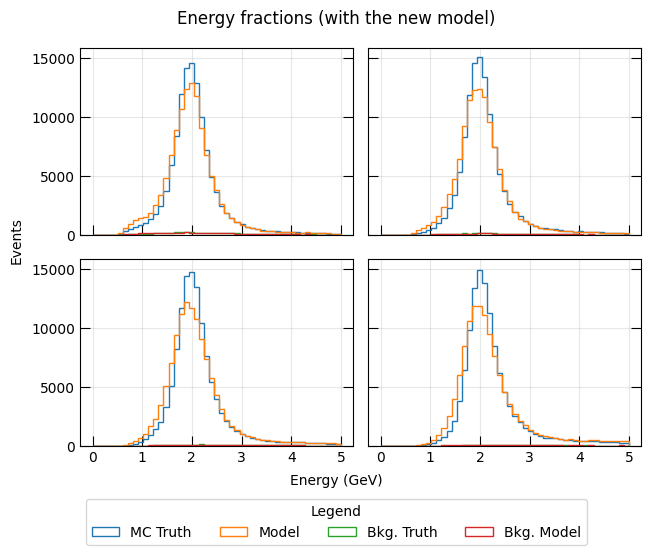

In [65]:
fig, axs = custom_subplots(2, 2, sharex=True, sharey=True)

axs = axs.flatten()

bins_conf = np.linspace(0, 5, 50)
model = 'rec.energy.numu.lstmnu'

for i in range(4):
    df_energy_frac = df_full_cuts[energy_frac_cuts_new[i]]
    
    axs[i].hist(
       df_energy_frac['trueEnu'],
        bins=bins_conf,
        histtype='step'
    )
    axs[i].hist(
        df_energy_frac[model],
        bins=bins_conf,
        histtype='step'
    )
    axs[i].hist(
        df_energy_frac[df_energy_frac['isNuMuCC'] == 0]['trueEnu'],
        bins=bins_conf,
        histtype='step'
    )
    axs[i].hist(
        df_energy_frac[df_energy_frac['isNuMuCC'] == 0][model],
        bins=bins_conf,
        histtype='step'
    )

    axs[i].grid(True, alpha=0.3)


fig.legend(
    axs[0].lines, 
    labels=[
        'MC Truth', 
        'Model',
        'Bkg. Truth',
        'Bkg. Model'
    ], 
    loc='lower center',
    ncol=4,
    bbox_to_anchor=(0.5, -0.15), 
    title='Legend'
)

fig.text(-0.01, 0.5, 'Events', va='center', rotation='vertical')
fig.text(0.5, -0.01, 'Energy (GeV)', ha='center', rotation='horizontal')

fig.suptitle('Energy fractions (with the new model)')

plt.tight_layout();

In [66]:
residuals_new = list()
purity_new = list()

for i in range(4):
    df_energy_frac = df_full_cuts[energy_frac_cuts_new[i]]

    residuals_new.append(
        calculate_residuals(
            df_energy_frac[df_energy_frac['trueEnu'] > 0]['rec.energy.numu.E'],
            df_energy_frac[df_energy_frac['trueEnu'] > 0]['trueEnu']
        )
    )

    purity_new.append(
        len(df_energy_frac[df_energy_frac['isNuMuCC']]) / len(df_energy_frac) 
        * 100
    )

In [67]:
results_new = """\
Bins        E. Res.       Purity
----        -------       -------
1     ....  {:5.2f}%  ....  {:5.2f}%
2     ....  {:5.2f}%  ....  {:5.2f}%
3     ....  {:5.2f}%  ....  {:5.2f}%
4     ....  {:5.2f}%  ....  {:5.2f}%
Com.  ....  {:5.2f}%  ....  {:5.2f}%
""".format(
    np.sqrt(np.mean(residuals_new[0]**2)) * 100,
    purity_new[0],
    np.sqrt(np.mean(residuals_new[1]**2)) * 100,
    purity_new[1],
    np.sqrt(np.mean(residuals_new[2]**2)) * 100,
    purity_new[2],
    np.sqrt(np.mean(residuals_new[3]**2)) * 100,
    purity_new[3],
    np.sqrt(np.mean(eres_new_model**2)) * 100,
    len(df_full_cuts[df_full_cuts['isNuMuCC']]) / len(df_full_cuts) * 100
)

print(results_new)

Bins        E. Res.       Purity
----        -------       -------
1     ....   9.94%  ....  95.29%
2     ....  12.61%  ....  96.74%
3     ....  14.69%  ....  97.45%
4     ....  18.30%  ....  97.73%
Com.  ....  12.33%  ....  96.80%



In [68]:
for i, r in enumerate(residuals_new):
    print(i + 1, 'mean: ', np.mean(r), 'std', np.std(r))

1 mean:  0.051100016 std 0.085202746
2 mean:  0.069850534 std 0.105007276
3 mean:  0.08177055 std 0.12199174
4 mean:  0.06676144 std 0.17039634


### Summary of results

In [69]:
print('Old Model\n---------')
print(results_old)
print()
print('New Model\n---------')
print(results_new)

Old Model
---------
Bins        E. Res.       Purity
----        -------       -------
1     ....   9.88%  ....  95.28%
2     ....  12.10%  ....  96.77%
3     ....  14.39%  ....  97.47%
4     ....  18.90%  ....  97.70%
Com.  ....  14.22%  ....  96.80%


New Model
---------
Bins        E. Res.       Purity
----        -------       -------
1     ....   9.94%  ....  95.29%
2     ....  12.61%  ....  96.74%
3     ....  14.69%  ....  97.45%
4     ....  18.30%  ....  97.73%
Com.  ....  12.33%  ....  96.80%



## Loading and using my model

In [70]:
model = keras.models.load_model(
    filepath='./../../labbook/models/Model--2024-01-19--00-33.h5'
)

In [86]:
useful_vars = [
    # Derived Quant.
    'pmu',
    'pt',
    'ptp',
    'recoq2',
    'cosBeamFirst',
    # Predicted energies
    'rec.energy.numu.hadclust.calE',
    'rec.energy.numu.hadclust.nhit',
    'rec.energy.numu.hadtrkE',
    'rec.energy.numu.lstmmuon',
    # Pre-selection CVN
    'rec.sel.cvnloosepreselptp.cosmicid',
    'rec.sel.cvnloosepreselptp.ncid',
    'rec.sel.cvnloosepreselptp.nueid',
    'rec.sel.cvnloosepreselptp.numuid',
    # Selection and PIDs
    'rec.sel.contain.cosbakcell',
    'rec.sel.remid.pid',
    'rec.sel.scann.scpid',
    # Time Slice
    'rec.slc.ncontplanes',
    'rec.slc.nhit',
    # Reconstructed Tracks
    'rec.trk.kalman.ntracks'
]

df_new = df[(df['trueEnu'] > 0) & (df['trueEnu'] < 5) & (df['isNuMuCC'])]

targets = [
        'rec.energy.numu.hadclust.calE',
        'rec.energy.numu.hadtrkE',
        'rec.energy.numu.lstmmuon',
        'rec.energy.numu.lstmnu',
    ]
for target in targets:
    df_new = df_new[df_new[target] >= 0.]

target_cols = [
        'rec.sel.cvnloosepreselptp.cosmicid',
        'rec.sel.cvnloosepreselptp.ncid',
        'rec.sel.cvnloosepreselptp.nueid',
        'rec.sel.cvnloosepreselptp.numuid',
        'rec.sel.remid.pid',
        'rec.sel.scann.scpid'
    ]
for col in target_cols:
    df_new[(df_new[col] < 0) & (df_new[col] > 1)] = 0.

var_corr_dict = dict(
    sorted(
        dict(df_new.corr()['trueEnu'][1:]).items(), 
        key=lambda x: np.abs(x[1]), 
        reverse=True
    )
)
strongly_corr_params = list(var_corr_dict.keys())[:7]

df_new_cut = nova_cuts.apply_all_cuts(df_new, except_='Containment')
df_new_useful = df_new_cut[useful_vars]

# TODO: Not ideal this, but it'll do for now
std_scaler = preprocessing.StandardScaler()
df_new_scaled = std_scaler.fit_transform(df_new_useful)

In [83]:
model_prediction = model.predict(df_test_scaled)

34659/34659 [==============================] - 27s 769us/step


## Plot of my model

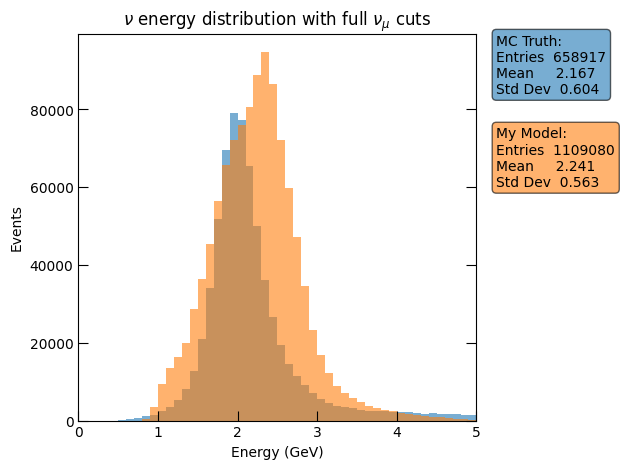

In [87]:
fig, ax = custom_subplots()

alpha_conf = 0.6
bins_conf = np.linspace(0, 5, 50 + 1)

labelled_hist(
    ax, 
    df_new_cut['trueEnu'], 
    bins=bins_conf, 
    alpha=alpha_conf, 
    label='MC Truth'
)

labelled_hist(
    ax, 
    model_prediction / 100, 
    bins=bins_conf, 
    alpha=alpha_conf, 
    label='My Model'
)

ax.set_xlim(0, 5)

ax.set_title(r'$\nu$ energy distribution with full $\nu_\mu$ cuts')

ax.set_xlabel(r'Energy (GeV)')
ax.set_ylabel(r'Events')

plt.tight_layout();
